In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import map_coordinates, gaussian_filter
from sklearn.metrics import precision_recall_fscore_support
import shutil

%run '/kaggle/input/cte-model/CTE.ipynb'
%run '/kaggle/input/cte-model/dataloader_imreshape_change.ipynb'

import numpy as np
import os

torch.Size([1, 105])


In [ ]:
class LabelSomCE(nn.Module):
	def __init__(self):
		super().__init__()

	def forward(self,x,target,smoothing=0.1):
		confidence = 1.0 - smoothing
		logprobs = F.log_softmax(x,dim=-1)
		nll_loss = - logprobs.gather(dim=-1,index=target.unsqueeze(1))
		nll_loss = nll_loss.squeeze(1)
		smooth_loss = -logprobs.mean(dim=-1)
		loss = confidence * nll_loss + smoothing * smooth_loss

		return loss.mean()

def download(folder,thetarfile):
    import urllib.request
    import tarfile
    ftpstream = urllib.request.urlopen(thetarfile)
    thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
    thetarfile.extractall(folder)
    thetarfile.close()

def extract_local_tar(local_tar_path, folder):
    with tarfile.open(local_tar_path, 'r|gz') as tar:
        tar.extractall(path=folder)

def download_cerug(folder):
    local_tarfile = "/CERUG-EN-train-images.tar.gz"
    extract_local_tar(local_tarfile, folder)
    #thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-train-images.tar.gz"
    #download(folder,thetarfile)
    local_tarfile = "/CERUG-EN-test-images.tar.gz"
    extract_local_tar(local_tarfile, folder)
    #thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-test-images.tar.gz"
    #download(folder,thetarfile)

def download_firemaker(folder):
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-train-images.tar.gz"
    download(folder,thetarfile)
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-test-images.tar.gz"
    download(folder,thetarfile)

def copy_folder_contents(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    for item in os.listdir(source_folder):
        source_path = os.path.join(source_folder, item)
        destination_path = os.path.join(destination_folder, item)
        if os.path.isdir(source_path):
            shutil.copytree(source_path, destination_path)
        else:
            shutil.copy2(source_path, destination_path)


In [ ]:
class ImageTransformer:
    def __init__(self, foldername, imgtype='png'):
        self.imgtype = imgtype
        self.folder = foldername
        self.imglist = self.get_imgList(self.folder)
        print(f'Image list: {self.imglist}')
        print(f'Number of images: {len(self.imglist)}')

    def get_imgList(self, folder):
        return [img for img in os.listdir(folder) if img.endswith(self.imgtype)]

    def elastic_transform(self, image, alpha, sigma):
        random_state = np.random.RandomState(None)
        shape = image.shape

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

        distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        return distorted_image

    def perspective_transform(self, image):
        width, height = image.size
        coeffs = self.find_coeffs(
            [(0, 0), (width, 0), (width, height), (0, height)],
            [(random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), height - random.randint(0, height // 4)),
             (random.randint(0, width // 4), height - random.randint(0, height // 4))]
        )
        return image.transform((width, height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

    def zoom_out_transform(self, image, scale=0.8):
        width, height = image.size
        new_width, new_height = int(width * scale), int(height * scale)
        return image.resize((new_width, new_height), Image.BICUBIC)

    def find_coeffs(self, pa, pb):
        matrix = []
        for p1, p2 in zip(pa, pb):
            matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1]])
            matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1] * p1[0], -p2[1] * p1[1]])

        A = np.matrix(matrix, dtype=float)
        B = np.array(pb).reshape(8)

        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

    def process_and_save_images(self):
        for imgfile in self.imglist:
            # Open the image
            image = Image.open(os.path.join(self.folder, imgfile)).convert('L')
            original_image = np.array(image)

            # Save original image
            original_image_filename = os.path.join(self.folder, imgfile)
            image.save(original_image_filename)

            # Elastic distortion
            elastic_image = self.elastic_transform(original_image, alpha=34, sigma=4)
            elastic_image = Image.fromarray(elastic_image).convert('L')
            elastic_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_1.' + self.imgtype)
            elastic_image.save(elastic_image_filename)

            # Perspective transformation
            perspective_image = self.perspective_transform(image)
            perspective_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_2.' + self.imgtype)
            perspective_image.save(perspective_image_filename)

            # Zoom out transformation
            zoom_out_image = self.zoom_out_transform(image, scale=0.8)  # Adjust scale as needed
            zoom_out_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_3.' + self.imgtype)
            zoom_out_image.save(zoom_out_image_filename)

Image list: ['Writer8383_03-01-line-0-n-11-y-50-x-2287-h-103-w-136.png', 'Writer7777_03-01-line-2-n-11-y-343-x-2333-h-127-w-158.png', 'Writer3232_03-01-line-0-n-0-y-39-x-49-h-87-w-100.png', 'Writer3737_03-01-line-4-n-3-y-608-x-703-h-148-w-90.png', 'Writer5555_03-01-line-0-n-8-y-8-x-1678-h-103-w-245.png', 'Writer0303_03-01-line-2-n-12-y-356-x-2001-h-102-w-237.png', 'Writer0909_03-01-line-3-n-13-y-512-x-2215-h-115-w-155.png', 'Writer3131_03-01-line-1-n-9-y-190-x-2272-h-97-w-203.png', 'Writer5050_03-01-line-5-n-4-y-790-x-1147-h-114-w-170.png', 'Writer7373_03-01-line-3-n-6-y-537-x-1577-h-115-w-158.png', 'Writer4040_03-01-line-2-n-4-y-304-x-930-h-138-w-91.png', 'Writer0303_03-01-line-2-n-6-y-356-x-1061-h-102-w-75.png', 'Writer9696_03-01-line-2-n-10-y-376-x-2180-h-95-w-105.png', 'Writer2929_03-01-line-2-n-4-y-354-x-742-h-120-w-125.png', 'Writer4444_03-01-line-1-n-8-y-152-x-1619-h-100-w-73.png', 'Writer1212_03-01-line-1-n-8-y-129-x-1969-h-131-w-128.png', 'Writer7171_03-01-line-3-n-4-y-521-x-1

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 0   avg testing loss is: 3.5346856444052817
Testing on epoch: 0 has accuracy: top1: 31.71 top5: 67.49
Precision: 38.82%, Recall: 32.06%, F1 Score: 26.67%


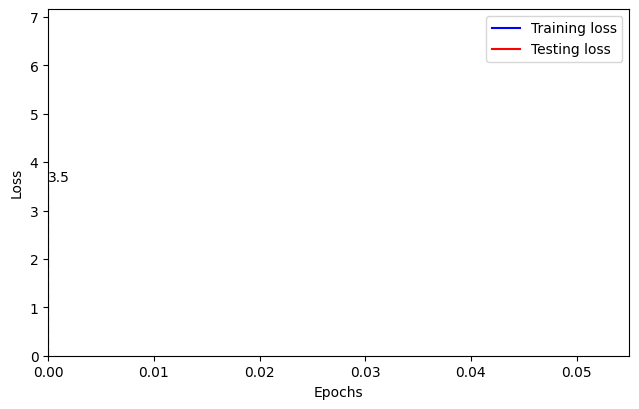

Traing epoch: 1   avg loss is: 3.8759411343357018


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 1   avg testing loss is: 3.1241904032935977
Testing on epoch: 1 has accuracy: top1: 37.59 top5: 74.20
Precision: 53.96%, Recall: 37.38%, F1 Score: 34.30%


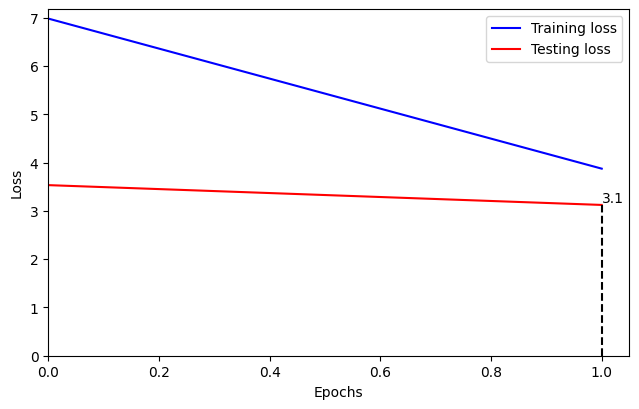

Traing epoch: 2   avg loss is: 2.708310211081254


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 2   avg testing loss is: 3.0631566946380233
Testing on epoch: 2 has accuracy: top1: 40.78 top5: 74.33
Precision: 56.22%, Recall: 41.15%, F1 Score: 38.01%


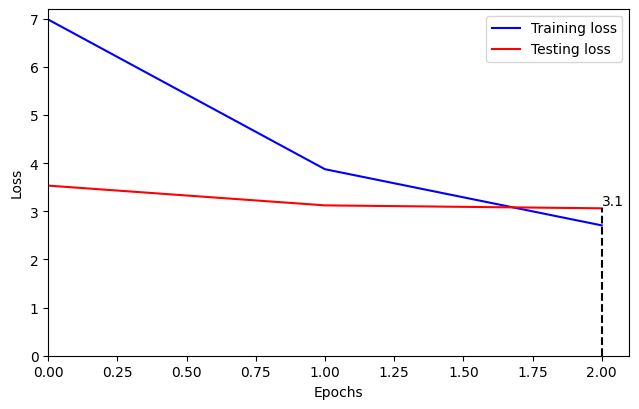

Traing epoch: 3   avg loss is: 2.220943539268092


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 3   avg testing loss is: 2.215056830477492
Testing on epoch: 3 has accuracy: top1: 57.95 top5: 89.53
Precision: 69.56%, Recall: 58.20%, F1 Score: 56.54%


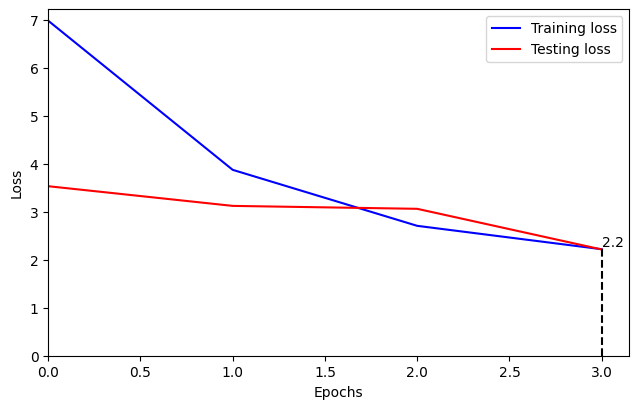

Traing epoch: 4   avg loss is: 1.9426124425519977
Testing epoch: 4   avg testing loss is: 2.1473264753632826
Testing on epoch: 4 has accuracy: top1: 59.04 top5: 90.95
Precision: 72.65%, Recall: 58.77%, F1 Score: 57.68%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


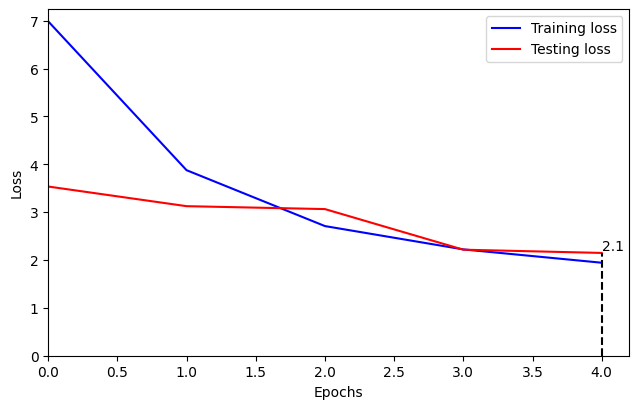

Traing epoch: 5   avg loss is: 1.774336829854731
Testing epoch: 5   avg testing loss is: 2.106251676134603
Testing on epoch: 5 has accuracy: top1: 60.52 top5: 91.96
Precision: 76.96%, Recall: 60.80%, F1 Score: 60.49%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


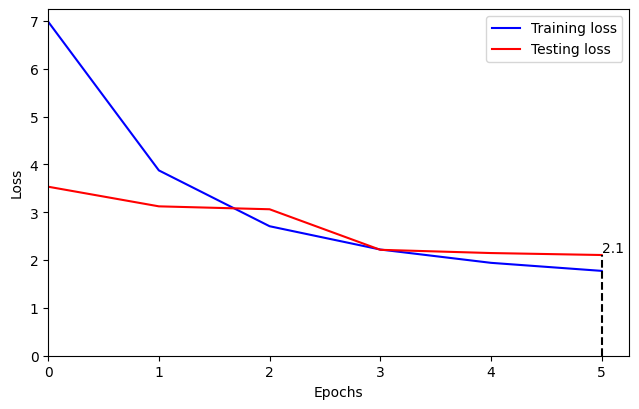

Traing epoch: 6   avg loss is: 1.6334236751522935
Testing epoch: 6   avg testing loss is: 1.6853614161690447
Testing on epoch: 6 has accuracy: top1: 75.64 top5: 95.75
Precision: 80.72%, Recall: 75.66%, F1 Score: 75.20%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


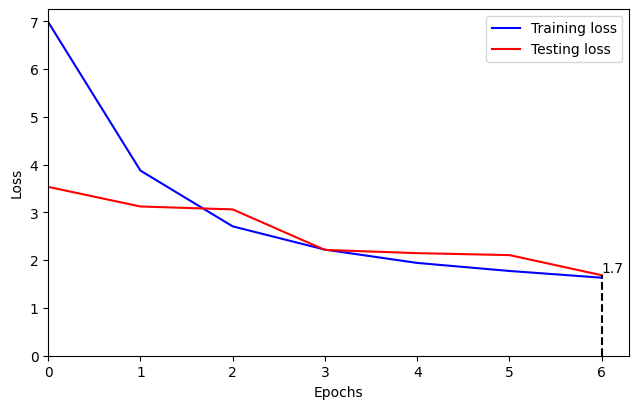

Traing epoch: 7   avg loss is: 1.5372522525620043
Testing epoch: 7   avg testing loss is: 1.7577501891929412
Testing on epoch: 7 has accuracy: top1: 72.34 top5: 94.64
Precision: 80.65%, Recall: 72.66%, F1 Score: 72.62%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


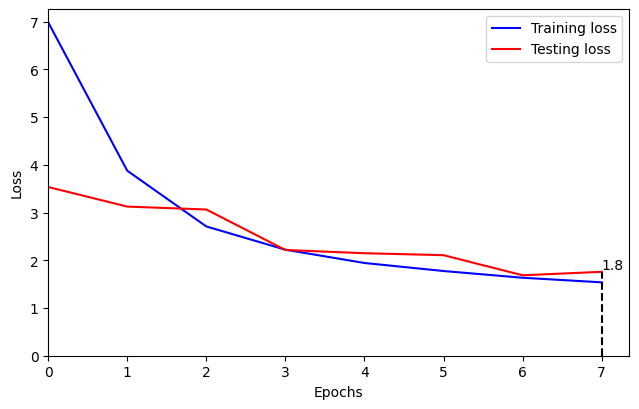

Traing epoch: 8   avg loss is: 1.4469121434395773
Testing epoch: 8   avg testing loss is: 1.854781662935037
Testing on epoch: 8 has accuracy: top1: 69.05 top5: 93.70
Precision: 79.65%, Recall: 68.94%, F1 Score: 69.44%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


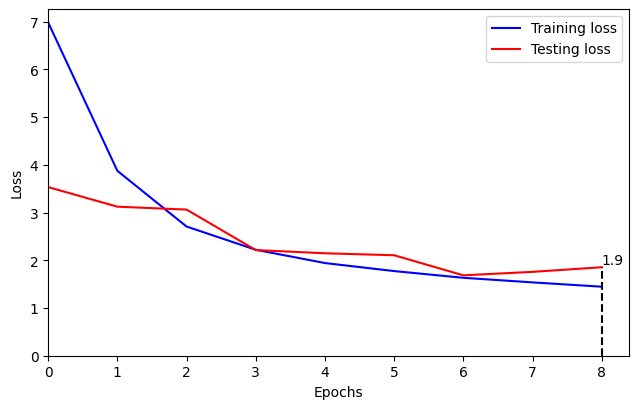

Traing epoch: 9   avg loss is: 1.3762004484210097


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 9   avg testing loss is: 2.0097308634226194
Testing on epoch: 9 has accuracy: top1: 65.07 top5: 91.91
Precision: 77.04%, Recall: 64.81%, F1 Score: 63.99%


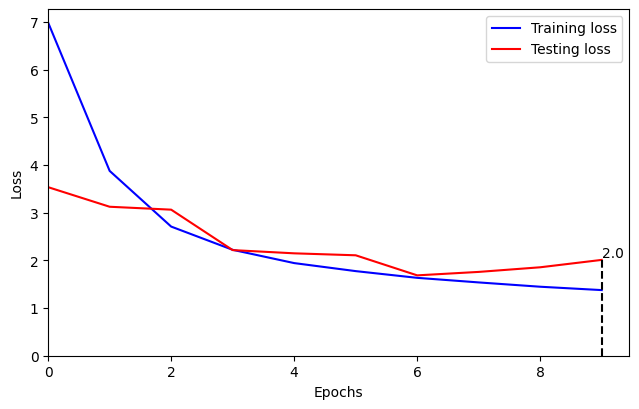

Traing epoch: 10   avg loss is: 1.1716523293863264
Testing epoch: 10   avg testing loss is: 1.5596153799247148
Testing on epoch: 10 has accuracy: top1: 77.41 top5: 95.75
Precision: 81.50%, Recall: 77.63%, F1 Score: 77.20%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


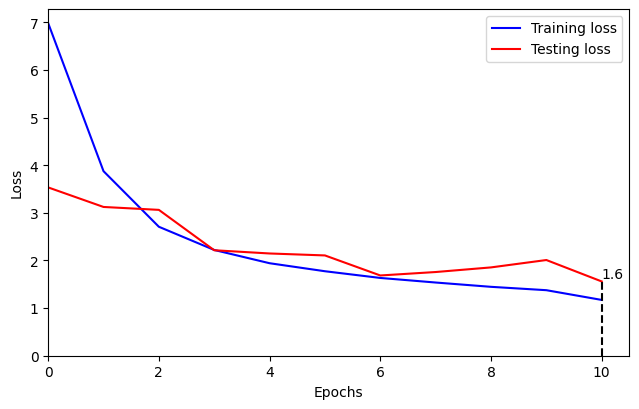

Traing epoch: 11   avg loss is: 1.1372059900718823
Testing epoch: 11   avg testing loss is: 1.4637465580972926
Testing on epoch: 11 has accuracy: top1: 82.27 top5: 97.43
Precision: 85.53%, Recall: 82.09%, F1 Score: 81.78%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


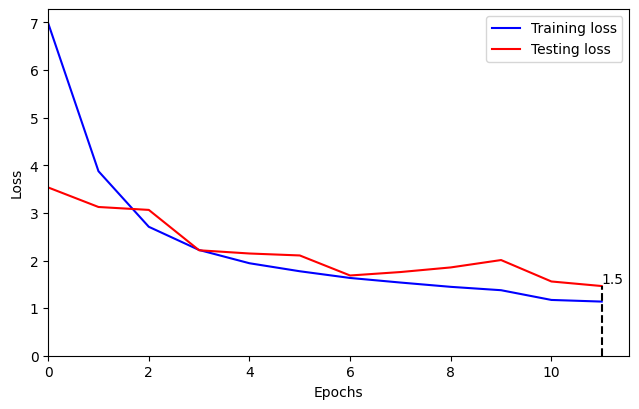

Traing epoch: 12   avg loss is: 1.1136338246077822
Testing epoch: 12   avg testing loss is: 1.4050179148017432
Testing on epoch: 12 has accuracy: top1: 84.10 top5: 97.31
Precision: 87.03%, Recall: 84.18%, F1 Score: 83.89%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


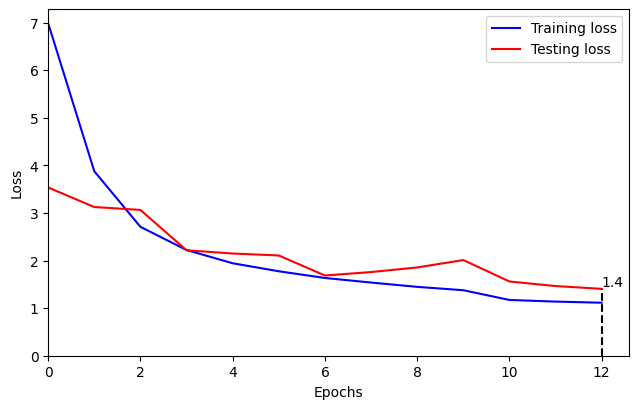

Traing epoch: 13   avg loss is: 1.083188836407243
Testing epoch: 13   avg testing loss is: 1.4414320939055114
Testing on epoch: 13 has accuracy: top1: 82.93 top5: 96.96
Precision: 86.22%, Recall: 83.30%, F1 Score: 82.77%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


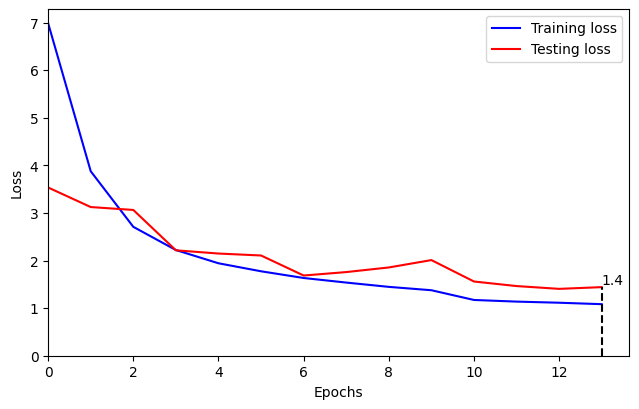

Traing epoch: 14   avg loss is: 1.0589932015067653
Testing epoch: 14   avg testing loss is: 1.3753157837368617
Testing on epoch: 14 has accuracy: top1: 84.06 top5: 97.93
Precision: 87.05%, Recall: 84.25%, F1 Score: 84.14%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


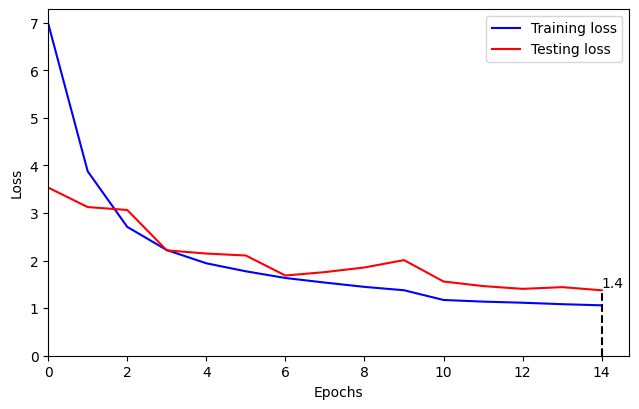

Traing epoch: 15   avg loss is: 1.0407481574593929
Testing epoch: 15   avg testing loss is: 1.4315611224308191
Testing on epoch: 15 has accuracy: top1: 81.47 top5: 97.27
Precision: 85.55%, Recall: 81.57%, F1 Score: 81.77%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


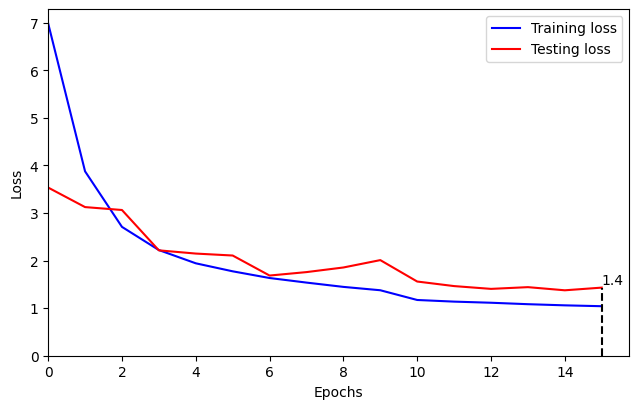

Traing epoch: 16   avg loss is: 1.0246501613499825
Testing epoch: 16   avg testing loss is: 1.429486190975641
Testing on epoch: 16 has accuracy: top1: 82.02 top5: 96.76
Precision: 85.64%, Recall: 82.32%, F1 Score: 82.16%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


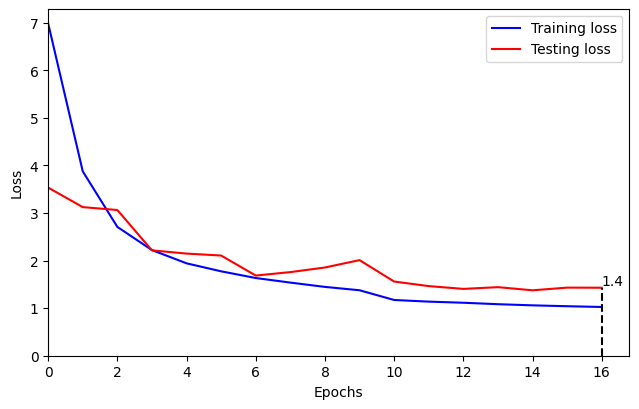

Traing epoch: 17   avg loss is: 1.007442830570957
Testing epoch: 17   avg testing loss is: 1.3102677731870491
Testing on epoch: 17 has accuracy: top1: 86.31 top5: 97.70
Precision: 88.02%, Recall: 86.30%, F1 Score: 86.07%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


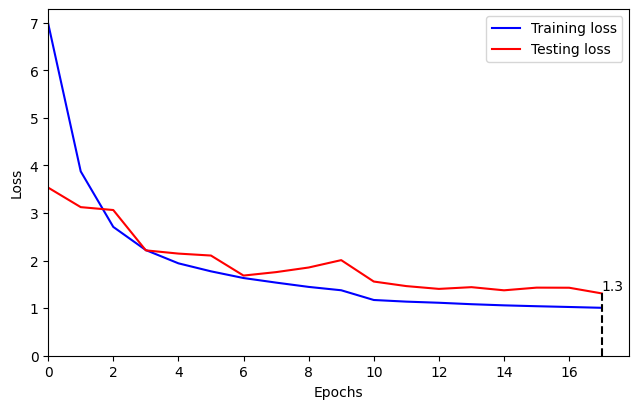

Traing epoch: 18   avg loss is: 0.9945628083379645
Testing epoch: 18   avg testing loss is: 1.4541867657613903
Testing on epoch: 18 has accuracy: top1: 80.85 top5: 96.26
Precision: 84.46%, Recall: 81.00%, F1 Score: 80.61%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


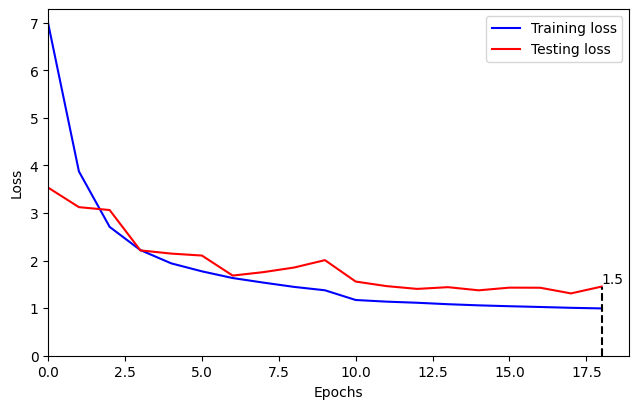

Traing epoch: 19   avg loss is: 0.9804020223282931
Testing epoch: 19   avg testing loss is: 1.5382720900473195
Testing on epoch: 19 has accuracy: top1: 78.31 top5: 95.08
Precision: 84.64%, Recall: 78.54%, F1 Score: 78.12%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


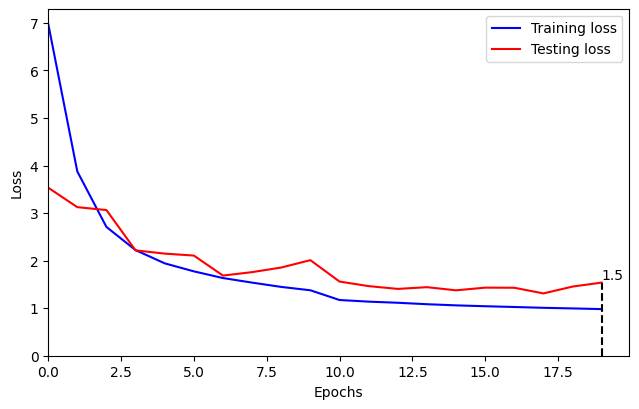

Traing epoch: 20   avg loss is: 0.9250341417914942
Testing epoch: 20   avg testing loss is: 1.2961396290877154
Testing on epoch: 20 has accuracy: top1: 86.29 top5: 97.62
Precision: 88.19%, Recall: 86.45%, F1 Score: 86.16%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


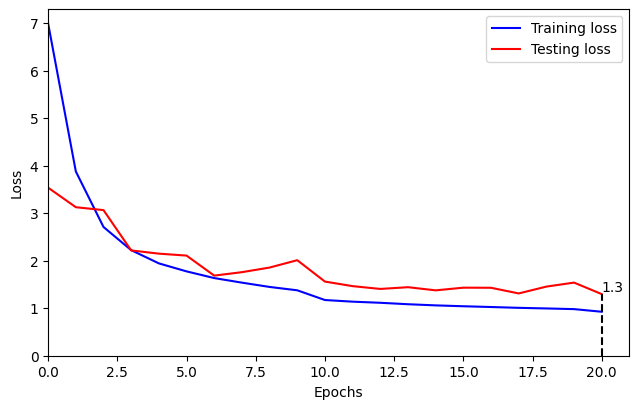

Traing epoch: 21   avg loss is: 0.9148320902439586
Testing epoch: 21   avg testing loss is: 1.267535955178032
Testing on epoch: 21 has accuracy: top1: 87.44 top5: 97.85
Precision: 88.74%, Recall: 87.61%, F1 Score: 87.38%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


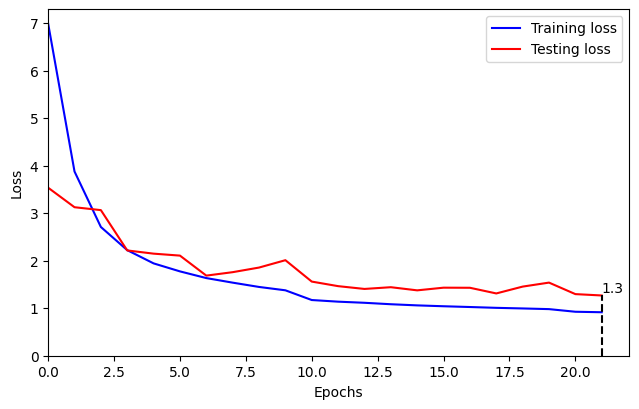

Traing epoch: 22   avg loss is: 0.9077851593703554
Testing epoch: 22   avg testing loss is: 1.2817122239932837
Testing on epoch: 22 has accuracy: top1: 86.91 top5: 97.58
Precision: 88.68%, Recall: 87.04%, F1 Score: 86.89%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


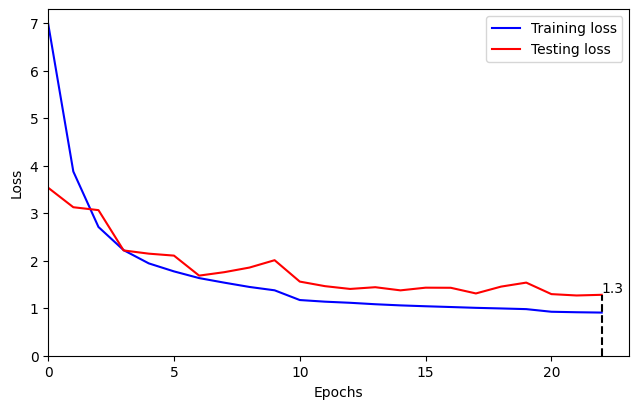

Traing epoch: 23   avg loss is: 0.9012541439658717
Testing epoch: 23   avg testing loss is: 1.2468643862510396
Testing on epoch: 23 has accuracy: top1: 88.24 top5: 98.05
Precision: 89.66%, Recall: 88.26%, F1 Score: 88.17%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


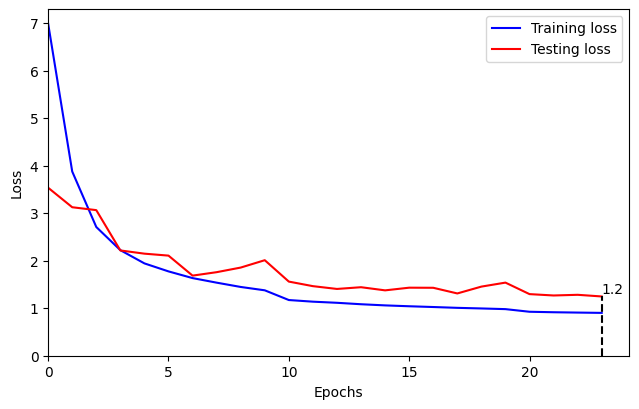

Traing epoch: 24   avg loss is: 0.8969107856248555
Testing epoch: 24   avg testing loss is: 1.2927689431612366
Testing on epoch: 24 has accuracy: top1: 86.44 top5: 97.50
Precision: 88.11%, Recall: 86.66%, F1 Score: 86.26%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


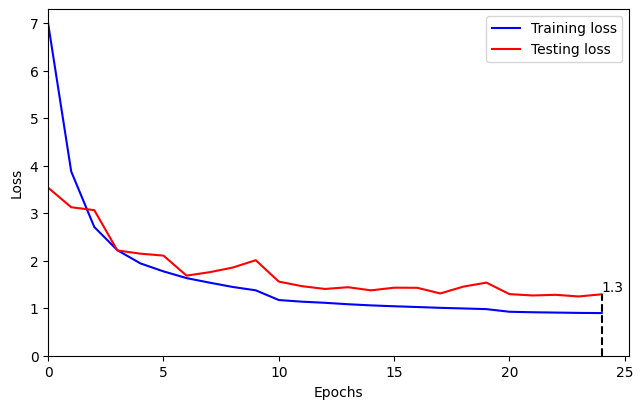

Traing epoch: 25   avg loss is: 0.8913542862105788
Testing epoch: 25   avg testing loss is: 1.2367662183963621
Testing on epoch: 25 has accuracy: top1: 87.56 top5: 98.11
Precision: 88.78%, Recall: 87.71%, F1 Score: 87.42%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


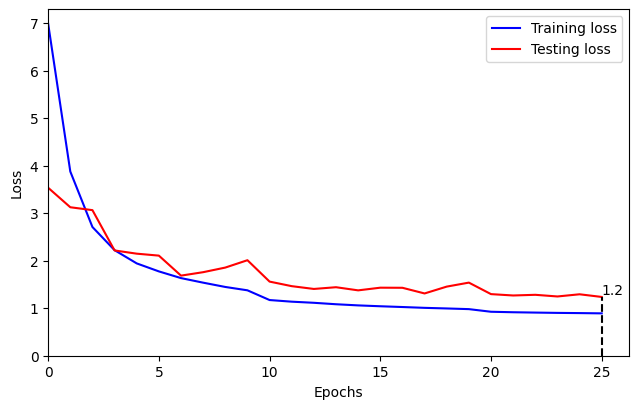

Traing epoch: 26   avg loss is: 0.8889295502294574
Testing epoch: 26   avg testing loss is: 1.1996120673102382
Testing on epoch: 26 has accuracy: top1: 89.62 top5: 98.38
Precision: 90.38%, Recall: 89.74%, F1 Score: 89.55%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


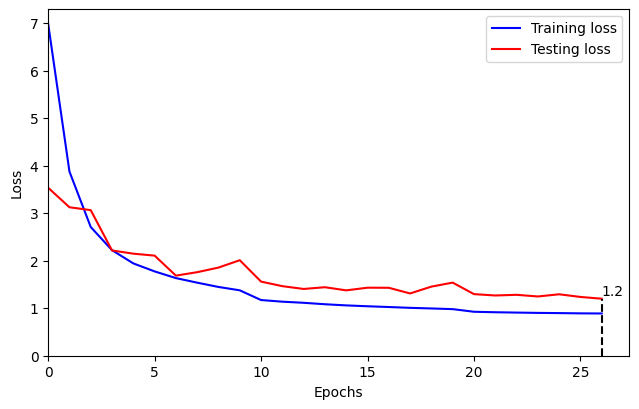

Traing epoch: 27   avg loss is: 0.8829188295414573
Testing epoch: 27   avg testing loss is: 1.2453881041654544
Testing on epoch: 27 has accuracy: top1: 87.85 top5: 98.21
Precision: 88.97%, Recall: 87.99%, F1 Score: 87.72%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


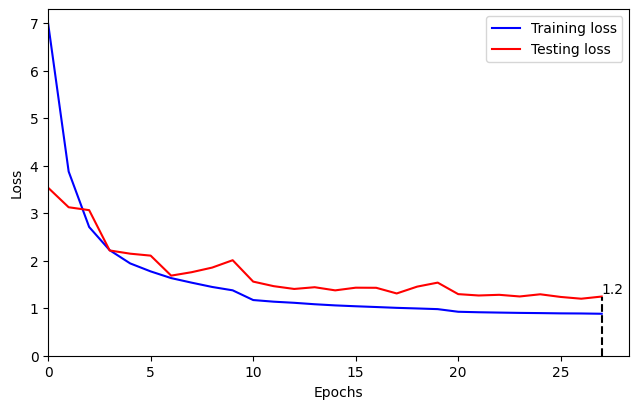

Traing epoch: 28   avg loss is: 0.8794253242224978
Testing epoch: 28   avg testing loss is: 1.2226459675488814
Testing on epoch: 28 has accuracy: top1: 88.69 top5: 98.38
Precision: 89.79%, Recall: 88.86%, F1 Score: 88.71%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


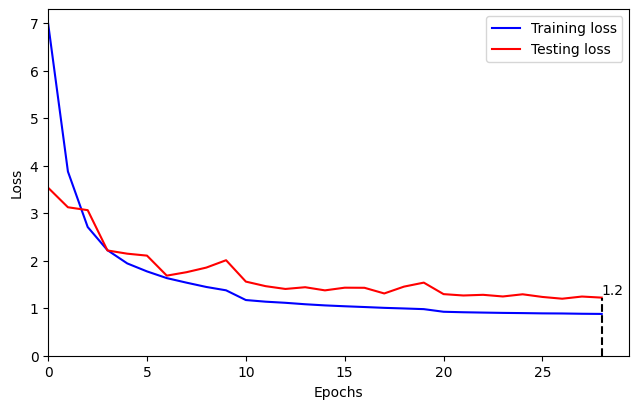

Traing epoch: 29   avg loss is: 0.8771259975015071
Testing epoch: 29   avg testing loss is: 1.302617153460363
Testing on epoch: 29 has accuracy: top1: 86.15 top5: 97.78
Precision: 87.91%, Recall: 86.32%, F1 Score: 86.17%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


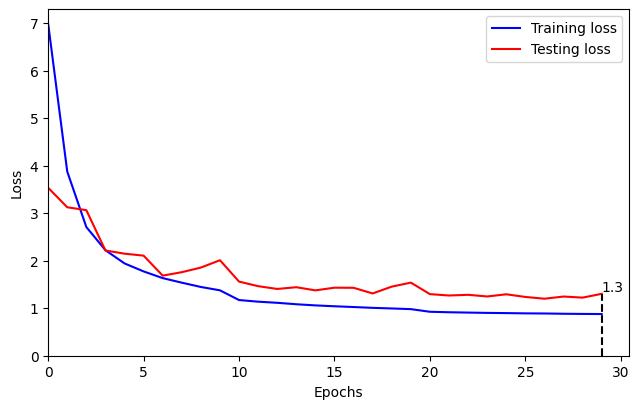

Traing epoch: 30   avg loss is: 0.8590548181115535
Testing epoch: 30   avg testing loss is: 1.1861761399890032
Testing on epoch: 30 has accuracy: top1: 90.19 top5: 98.54
Precision: 90.84%, Recall: 90.23%, F1 Score: 90.12%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


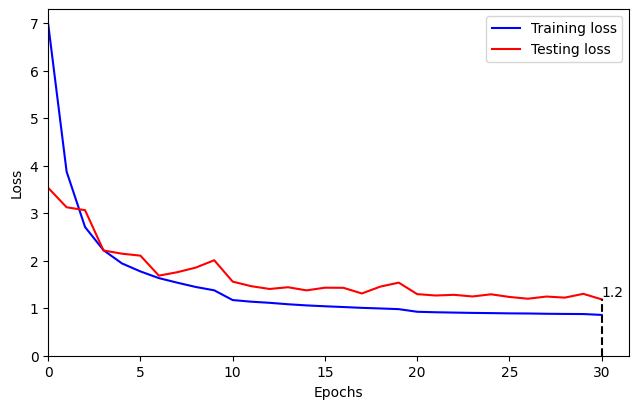

Traing epoch: 31   avg loss is: 0.8554460578634028
Testing epoch: 31   avg testing loss is: 1.2080612851080494
Testing on epoch: 31 has accuracy: top1: 89.66 top5: 98.24
Precision: 90.51%, Recall: 89.76%, F1 Score: 89.62%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


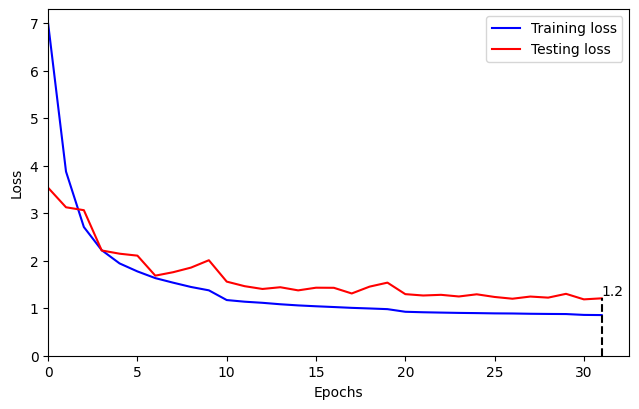

Traing epoch: 32   avg loss is: 0.8541668049076148
Testing epoch: 32   avg testing loss is: 1.2082508061533777
Testing on epoch: 32 has accuracy: top1: 89.31 top5: 98.34
Precision: 90.38%, Recall: 89.43%, F1 Score: 89.29%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


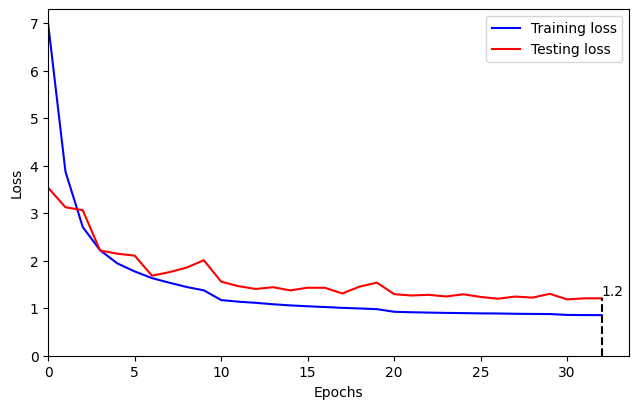

Traing epoch: 33   avg loss is: 0.8518173188912241
Testing epoch: 33   avg testing loss is: 1.203947406691554
Testing on epoch: 33 has accuracy: top1: 89.68 top5: 98.34
Precision: 90.45%, Recall: 89.75%, F1 Score: 89.60%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


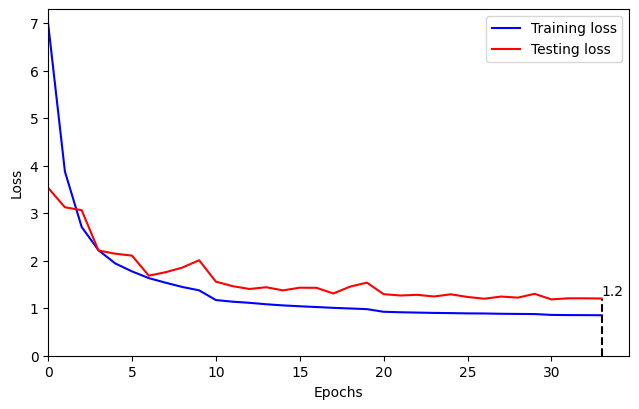

Traing epoch: 34   avg loss is: 0.8498155322827791
Testing epoch: 34   avg testing loss is: 1.1942331686940892
Testing on epoch: 34 has accuracy: top1: 90.54 top5: 98.56
Precision: 91.34%, Recall: 90.57%, F1 Score: 90.57%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


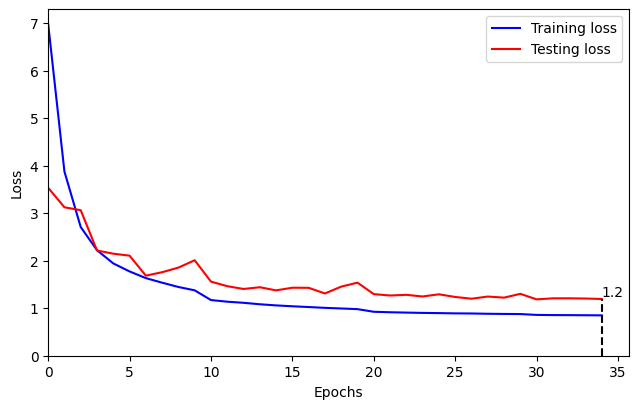

Traing epoch: 35   avg loss is: 0.848753150178675
Testing epoch: 35   avg testing loss is: 1.2156340305307574
Testing on epoch: 35 has accuracy: top1: 89.74 top5: 98.44
Precision: 90.59%, Recall: 89.81%, F1 Score: 89.62%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


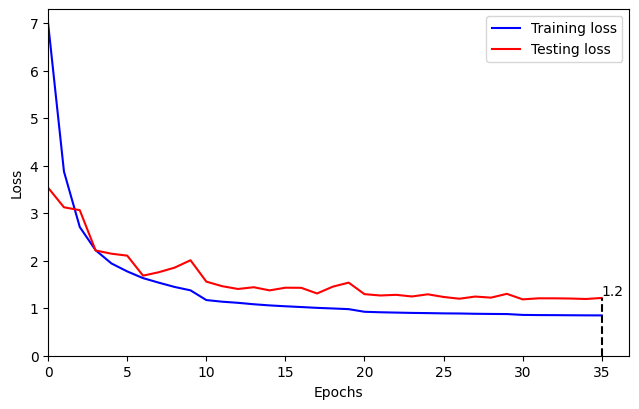

Traing epoch: 36   avg loss is: 0.8466901569199143
Testing epoch: 36   avg testing loss is: 1.235219440356222
Testing on epoch: 36 has accuracy: top1: 88.41 top5: 97.91
Precision: 89.63%, Recall: 88.62%, F1 Score: 88.38%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


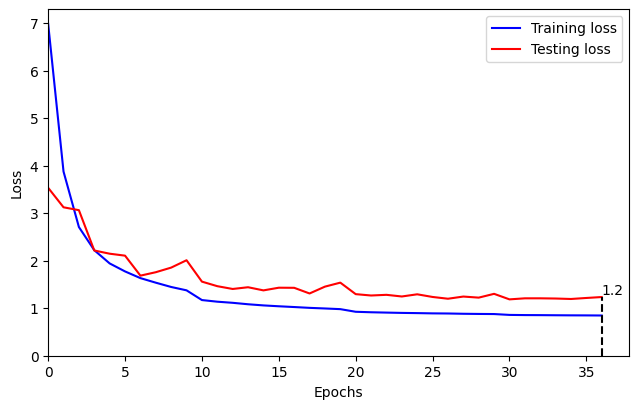

Traing epoch: 37   avg loss is: 0.8452551461939226
Testing epoch: 37   avg testing loss is: 1.211821311359465
Testing on epoch: 37 has accuracy: top1: 89.76 top5: 98.44
Precision: 90.57%, Recall: 89.87%, F1 Score: 89.70%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


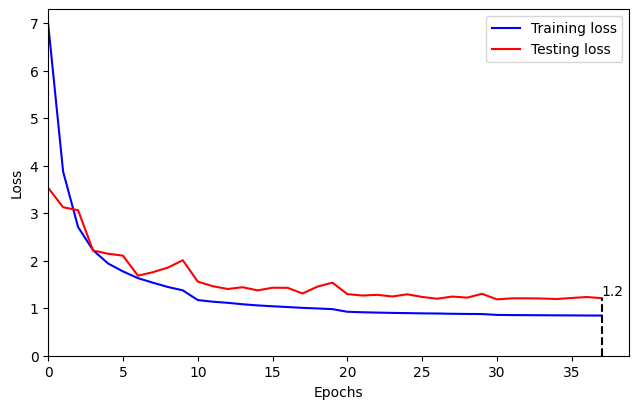

Traing epoch: 38   avg loss is: 0.8445159544024551
Testing epoch: 38   avg testing loss is: 1.1949177259968078
Testing on epoch: 38 has accuracy: top1: 90.07 top5: 98.46
Precision: 90.78%, Recall: 90.21%, F1 Score: 90.02%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


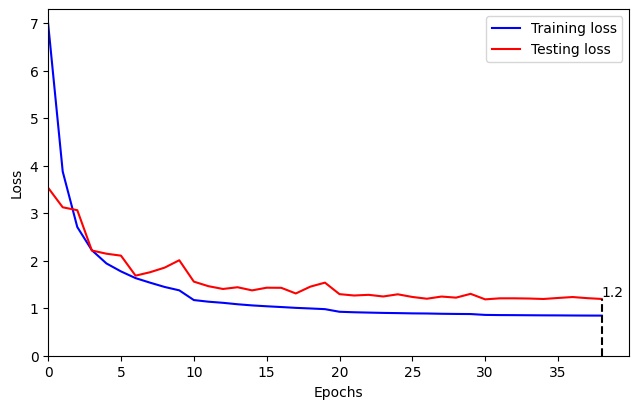

Traing epoch: 39   avg loss is: 0.8432161184779384
Testing epoch: 39   avg testing loss is: 1.2066527341385125
Testing on epoch: 39 has accuracy: top1: 90.11 top5: 98.46
Precision: 91.01%, Recall: 90.21%, F1 Score: 90.07%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


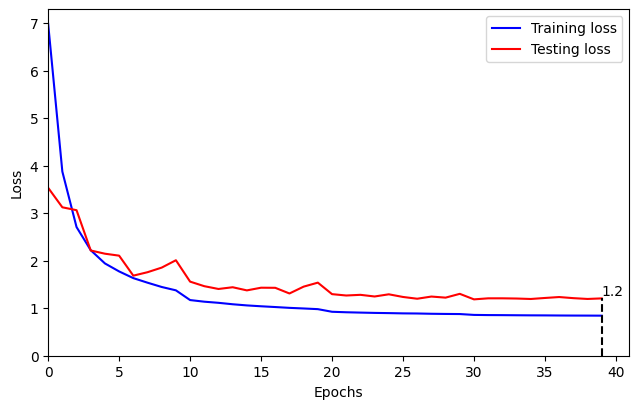

Traing epoch: 40   avg loss is: 0.8364296273181313
Testing epoch: 40   avg testing loss is: 1.1912809740345798
Testing on epoch: 40 has accuracy: top1: 90.85 top5: 98.40
Precision: 91.58%, Recall: 90.91%, F1 Score: 90.78%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


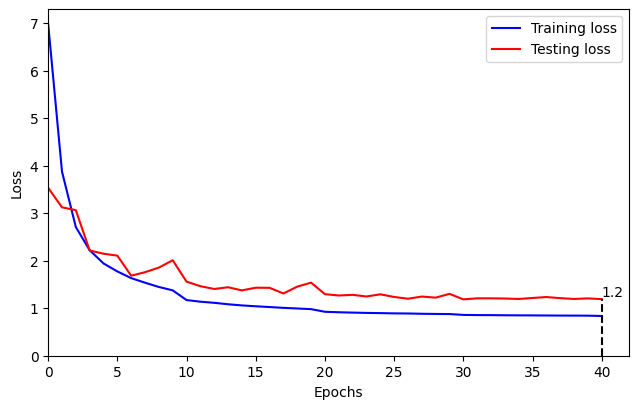

Traing epoch: 41   avg loss is: 0.8350791735398142
Testing epoch: 41   avg testing loss is: 1.1969273292758382
Testing on epoch: 41 has accuracy: top1: 89.99 top5: 98.30
Precision: 90.76%, Recall: 90.09%, F1 Score: 89.95%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


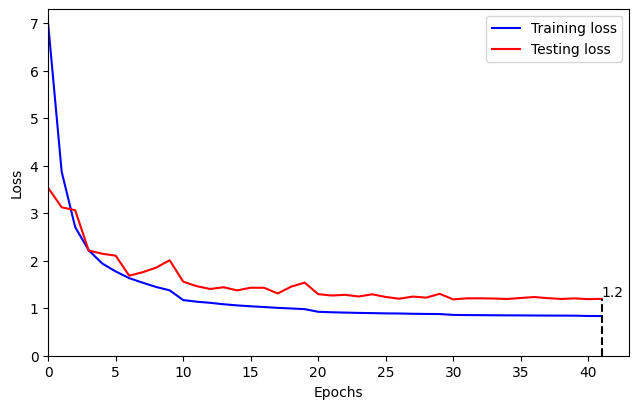

Traing epoch: 42   avg loss is: 0.8344296057182445
Testing epoch: 42   avg testing loss is: 1.1998426451861302
Testing on epoch: 42 has accuracy: top1: 90.48 top5: 98.54
Precision: 91.01%, Recall: 90.63%, F1 Score: 90.41%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


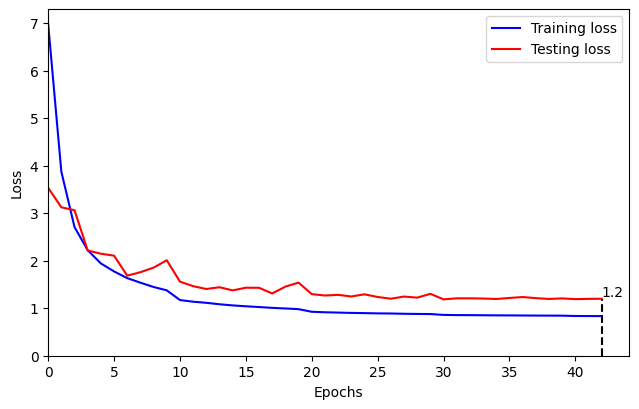

Traing epoch: 43   avg loss is: 0.8337264931829352
Testing epoch: 43   avg testing loss is: 1.20314426529816
Testing on epoch: 43 has accuracy: top1: 90.40 top5: 98.48
Precision: 91.13%, Recall: 90.48%, F1 Score: 90.37%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


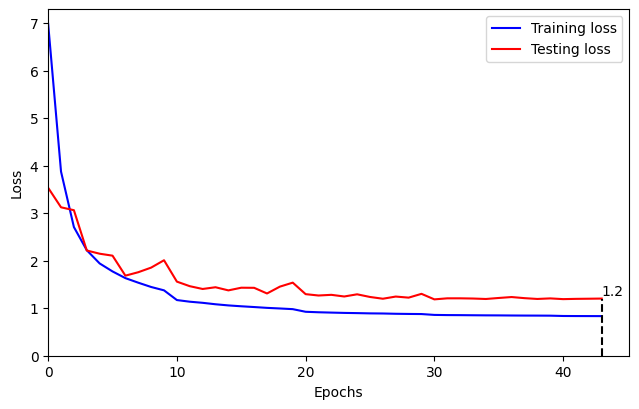

Traing epoch: 44   avg loss is: 0.8319258540973329
Testing epoch: 44   avg testing loss is: 1.1734093080428531
Testing on epoch: 44 has accuracy: top1: 91.09 top5: 98.77
Precision: 91.56%, Recall: 91.13%, F1 Score: 91.02%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


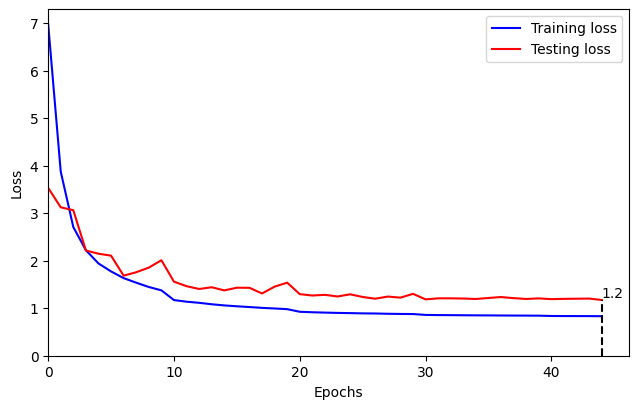

Traing epoch: 45   avg loss is: 0.8322952114490041
Testing epoch: 45   avg testing loss is: 1.1853366967673613
Testing on epoch: 45 has accuracy: top1: 90.75 top5: 98.60
Precision: 91.41%, Recall: 90.85%, F1 Score: 90.70%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


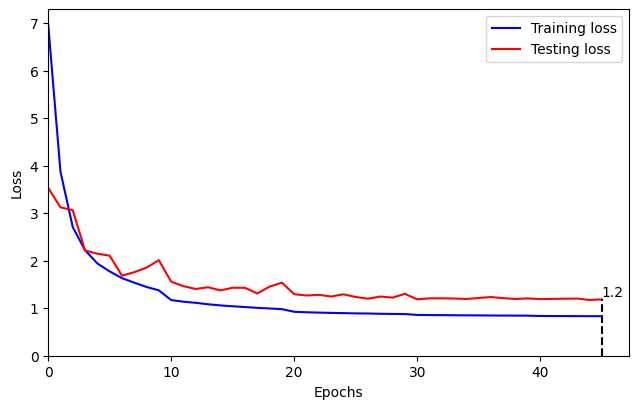

Traing epoch: 46   avg loss is: 0.8308192758392869
Testing epoch: 46   avg testing loss is: 1.1746603822411035
Testing on epoch: 46 has accuracy: top1: 90.75 top5: 98.60
Precision: 91.51%, Recall: 90.84%, F1 Score: 90.74%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


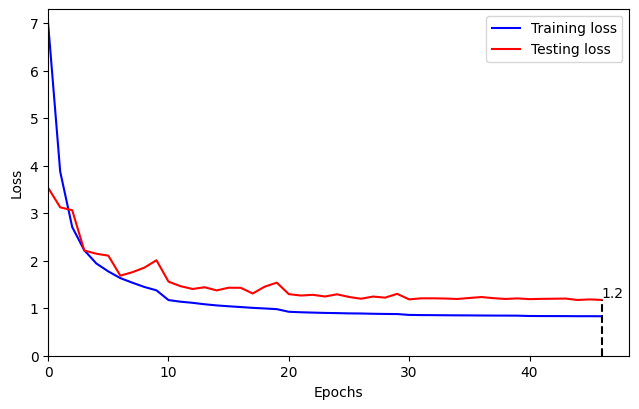

Traing epoch: 47   avg loss is: 0.8304386742491471
Testing epoch: 47   avg testing loss is: 1.1767227157625453
Testing on epoch: 47 has accuracy: top1: 90.77 top5: 98.63
Precision: 91.44%, Recall: 90.85%, F1 Score: 90.70%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


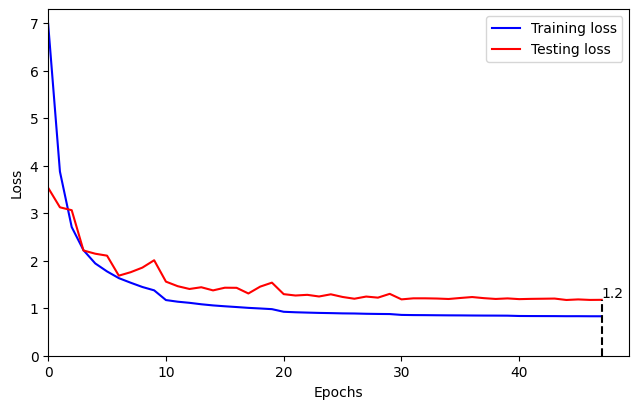

Traing epoch: 48   avg loss is: 0.8304519173136928
Testing epoch: 48   avg testing loss is: 1.1763547868743491
Testing on epoch: 48 has accuracy: top1: 90.93 top5: 98.52
Precision: 91.46%, Recall: 91.03%, F1 Score: 90.87%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


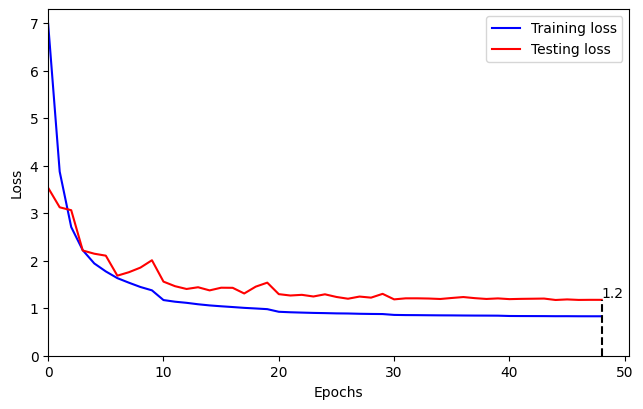

Traing epoch: 49   avg loss is: 0.8295948870976766
Testing epoch: 49   avg testing loss is: 1.182141395187081
Testing on epoch: 49 has accuracy: top1: 90.87 top5: 98.63
Precision: 91.51%, Recall: 90.93%, F1 Score: 90.85%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


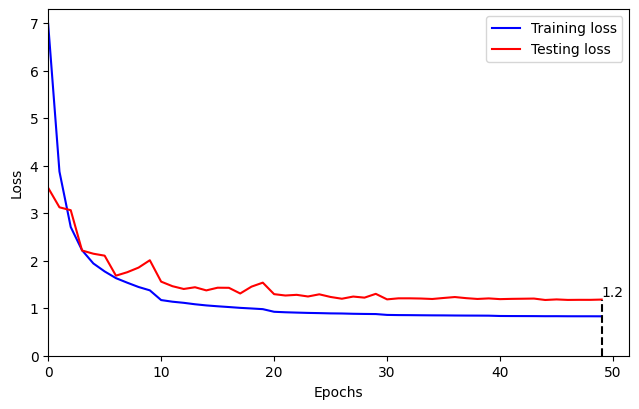

Traing epoch: 50   avg loss is: 0.8265177396305821
Testing epoch: 50   avg testing loss is: 1.2079554604964093
Testing on epoch: 50 has accuracy: top1: 90.21 top5: 98.42
Precision: 90.82%, Recall: 90.29%, F1 Score: 90.14%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


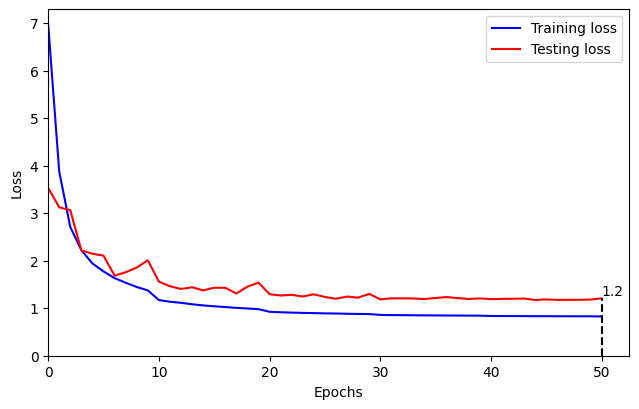

Traing epoch: 51   avg loss is: 0.8263949988181131
Testing epoch: 51   avg testing loss is: 1.1992846268731114
Testing on epoch: 51 has accuracy: top1: 90.52 top5: 98.56
Precision: 91.10%, Recall: 90.62%, F1 Score: 90.47%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


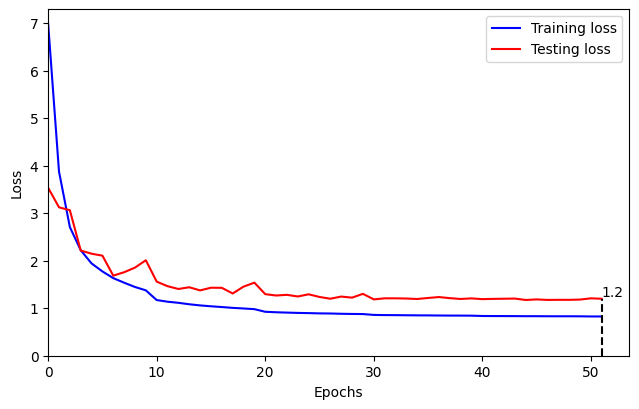

Traing epoch: 52   avg loss is: 0.8257595297328213
Testing epoch: 52   avg testing loss is: 1.2152390010260348
Testing on epoch: 52 has accuracy: top1: 90.48 top5: 98.58
Precision: 91.13%, Recall: 90.61%, F1 Score: 90.47%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


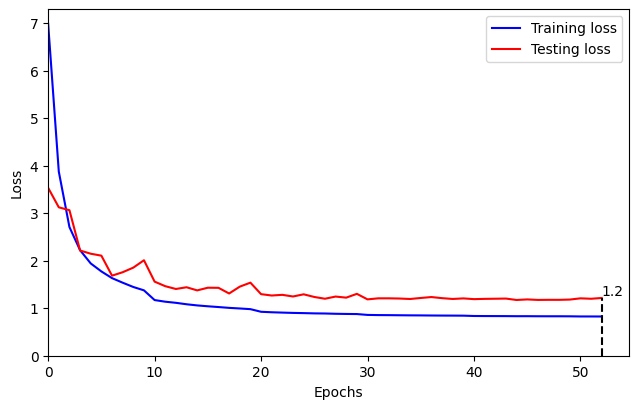

Traing epoch: 53   avg loss is: 0.8256887771790488
Testing epoch: 53   avg testing loss is: 1.19575860697161
Testing on epoch: 53 has accuracy: top1: 90.77 top5: 98.56
Precision: 91.39%, Recall: 90.89%, F1 Score: 90.72%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


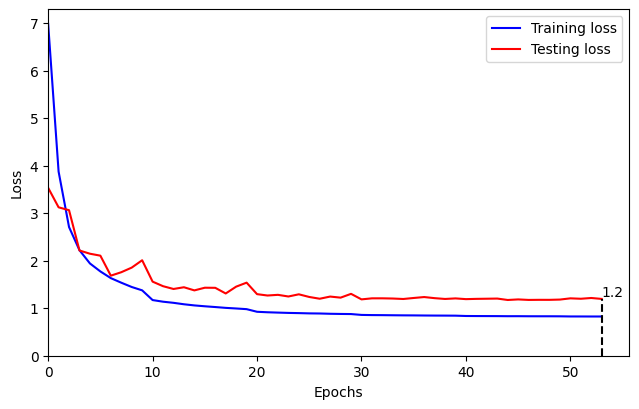

Traing epoch: 54   avg loss is: 0.8253327332881459
Testing epoch: 54   avg testing loss is: 1.1849948080529304
Testing on epoch: 54 has accuracy: top1: 90.85 top5: 98.58
Precision: 91.49%, Recall: 90.94%, F1 Score: 90.80%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


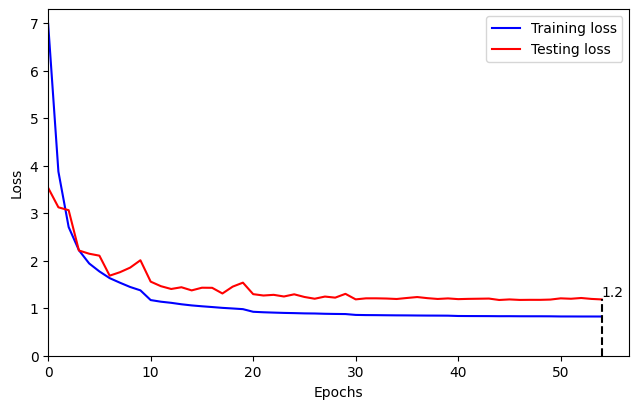

Traing epoch: 55   avg loss is: 0.8251488857101976
Testing epoch: 55   avg testing loss is: 1.2154289283485056
Testing on epoch: 55 has accuracy: top1: 90.31 top5: 98.44
Precision: 90.92%, Recall: 90.40%, F1 Score: 90.26%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


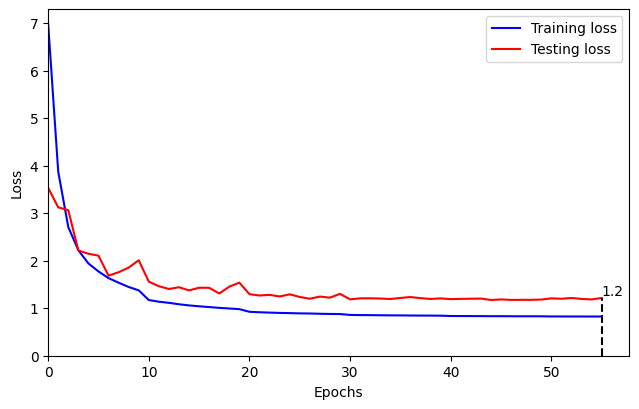

Traing epoch: 56   avg loss is: 0.8245160682996114
Testing epoch: 56   avg testing loss is: 1.182042419910431
Testing on epoch: 56 has accuracy: top1: 91.46 top5: 98.67
Precision: 91.91%, Recall: 91.57%, F1 Score: 91.43%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


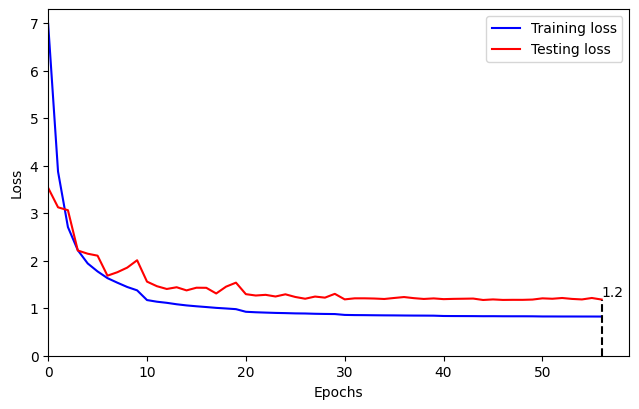

Traing epoch: 57   avg loss is: 0.8246682417183592
Testing epoch: 57   avg testing loss is: 1.177723181581943
Testing on epoch: 57 has accuracy: top1: 90.93 top5: 98.67
Precision: 91.45%, Recall: 91.02%, F1 Score: 90.88%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


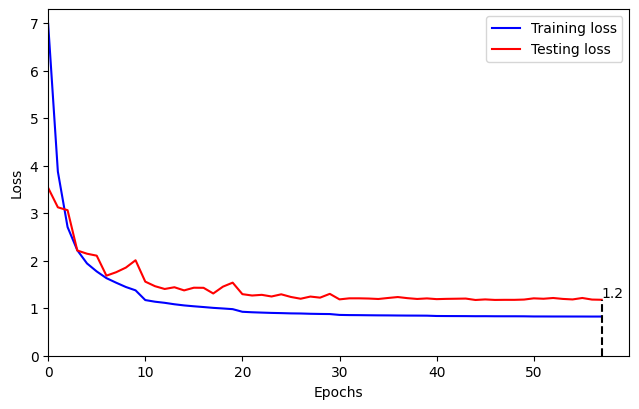

Traing epoch: 58   avg loss is: 0.8235697940776222
Testing epoch: 58   avg testing loss is: 1.1916722378626792
Testing on epoch: 58 has accuracy: top1: 90.89 top5: 98.58
Precision: 91.46%, Recall: 90.97%, F1 Score: 90.85%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


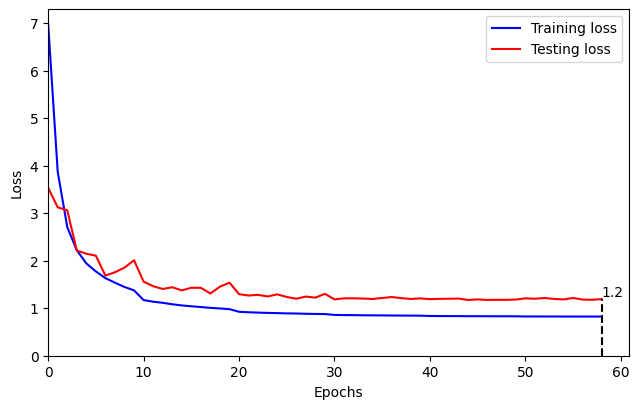

Traing epoch: 59   avg loss is: 0.8235722849243565
Testing epoch: 59   avg testing loss is: 1.1876278942990526
Testing on epoch: 59 has accuracy: top1: 91.20 top5: 98.58
Precision: 91.68%, Recall: 91.26%, F1 Score: 91.17%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


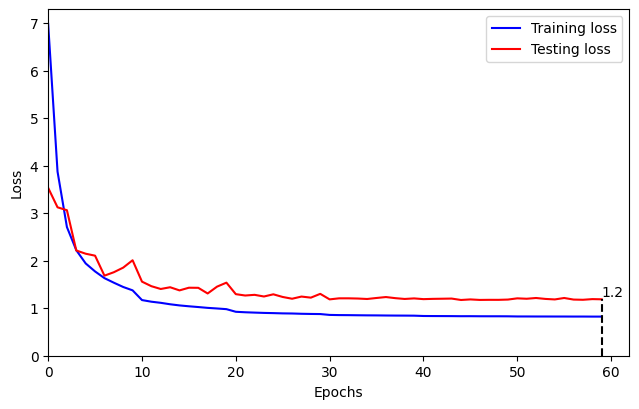

Traing epoch: 60   avg loss is: 0.8226504073226661
Testing epoch: 60   avg testing loss is: 1.1967283190225144
Testing on epoch: 60 has accuracy: top1: 90.81 top5: 98.60
Precision: 91.46%, Recall: 90.92%, F1 Score: 90.77%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


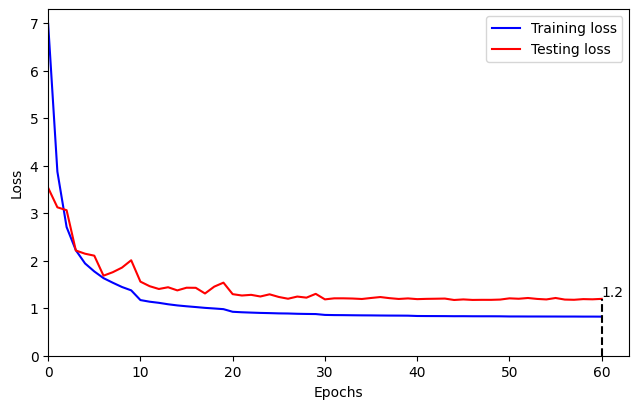

Traing epoch: 61   avg loss is: 0.8224744725645634
Testing epoch: 61   avg testing loss is: 1.1889021132965325
Testing on epoch: 61 has accuracy: top1: 90.93 top5: 98.62
Precision: 91.48%, Recall: 91.01%, F1 Score: 90.85%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


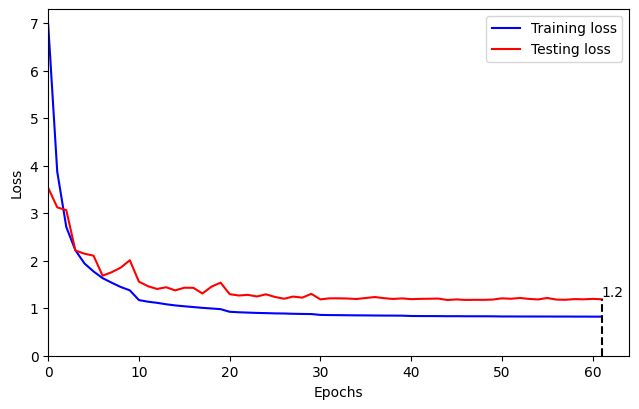

Traing epoch: 62   avg loss is: 0.821987736266956
Testing epoch: 62   avg testing loss is: 1.1995231557486585
Testing on epoch: 62 has accuracy: top1: 90.91 top5: 98.48
Precision: 91.53%, Recall: 90.99%, F1 Score: 90.85%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


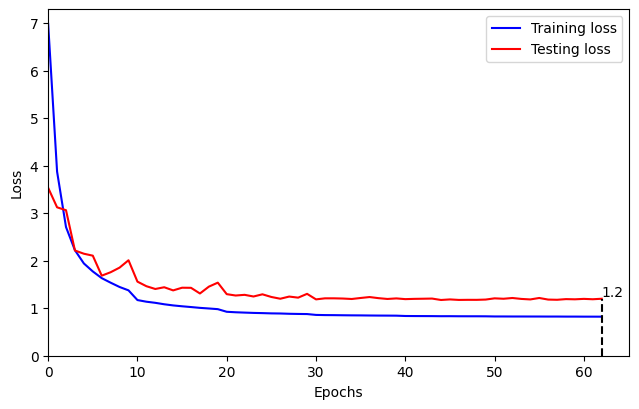

Traing epoch: 63   avg loss is: 0.8221786243455452
Testing epoch: 63   avg testing loss is: 1.199125156224331
Testing on epoch: 63 has accuracy: top1: 90.95 top5: 98.60
Precision: 91.47%, Recall: 91.03%, F1 Score: 90.88%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


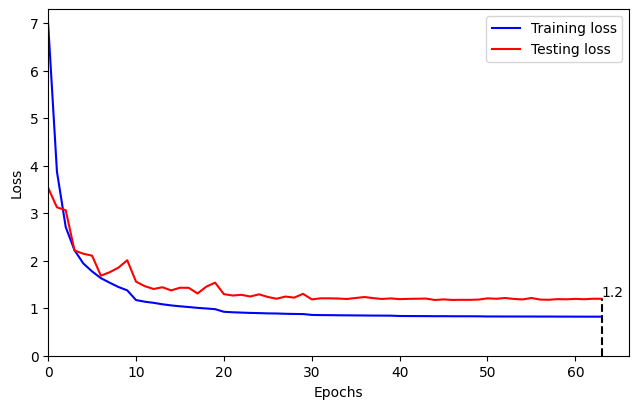

Traing epoch: 64   avg loss is: 0.8214997842437343
Testing epoch: 64   avg testing loss is: 1.195622640421086
Testing on epoch: 64 has accuracy: top1: 91.01 top5: 98.63
Precision: 91.56%, Recall: 91.09%, F1 Score: 90.92%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


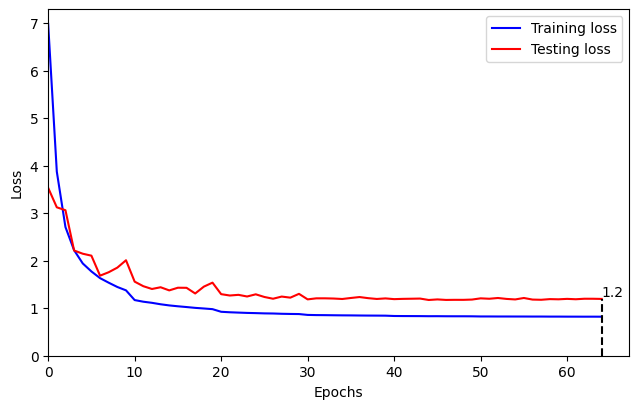

Traing epoch: 65   avg loss is: 0.8216116128469768
Testing epoch: 65   avg testing loss is: 1.1841505452108532
Testing on epoch: 65 has accuracy: top1: 91.11 top5: 98.73
Precision: 91.59%, Recall: 91.18%, F1 Score: 91.05%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


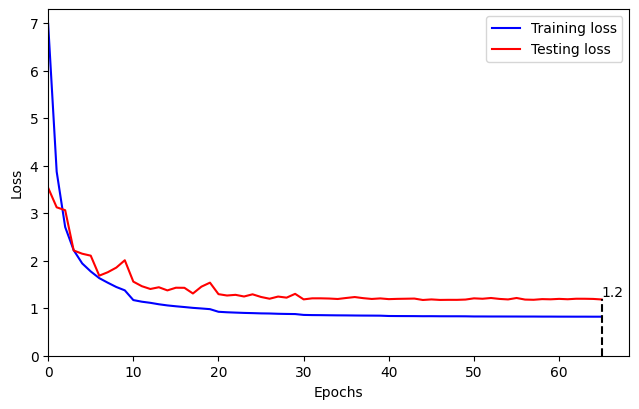

Traing epoch: 66   avg loss is: 0.8213272423911513
Testing epoch: 66   avg testing loss is: 1.1855413999141562
Testing on epoch: 66 has accuracy: top1: 91.18 top5: 98.65
Precision: 91.73%, Recall: 91.26%, F1 Score: 91.12%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


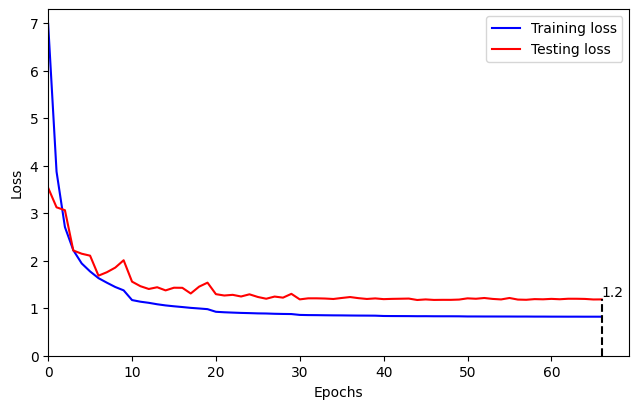

Traing epoch: 67   avg loss is: 0.821470081764355
Testing epoch: 67   avg testing loss is: 1.2038745046404664
Testing on epoch: 67 has accuracy: top1: 90.75 top5: 98.56
Precision: 91.37%, Recall: 90.84%, F1 Score: 90.67%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


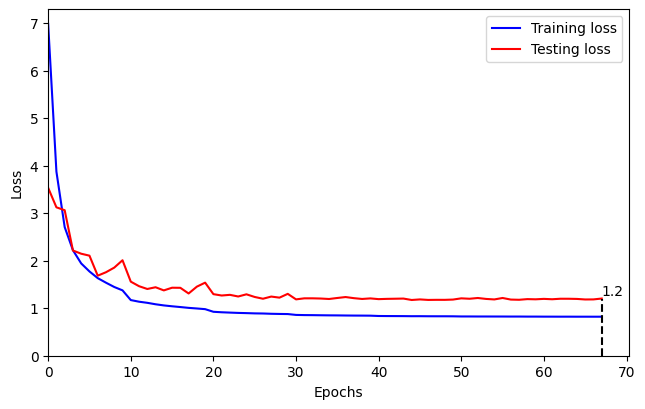

Traing epoch: 68   avg loss is: 0.8212448567256593
Testing epoch: 68   avg testing loss is: 1.1985809829004828
Testing on epoch: 68 has accuracy: top1: 90.81 top5: 98.62
Precision: 91.38%, Recall: 90.89%, F1 Score: 90.75%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


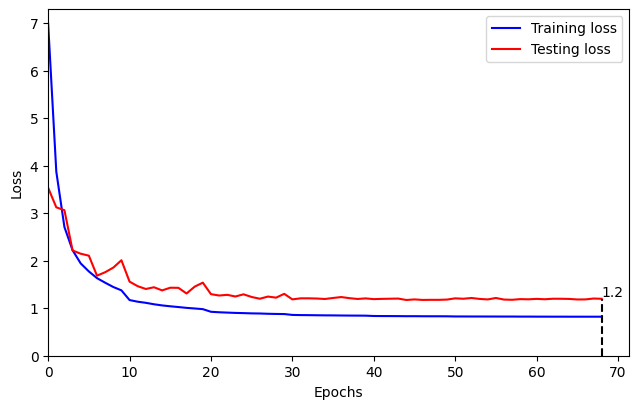

Traing epoch: 69   avg loss is: 0.8206822595261691
Testing epoch: 69   avg testing loss is: 1.195651081492225
Testing on epoch: 69 has accuracy: top1: 90.89 top5: 98.63
Precision: 91.45%, Recall: 90.97%, F1 Score: 90.81%


/tmp/ipykernel_24/1161670399.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/1161670399.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


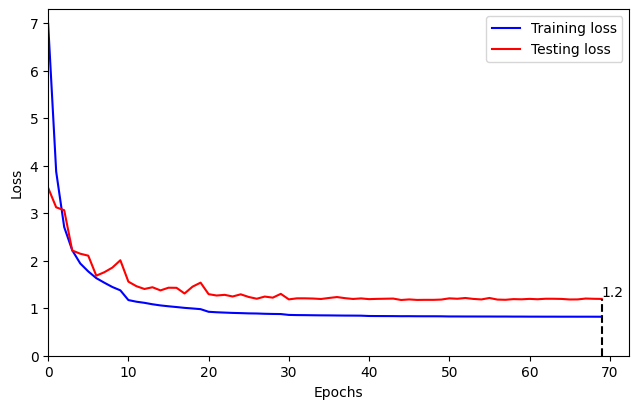

In [ ]:
class DeepWriter_Train:
    def __init__(self,dataset='CERUG-EN',imgtype='png'):

        self.dataset = dataset
        self.folder = dataset
        #self.labelfolder = 'dataset/'

        if not os.path.exists(self.folder):
            if dataset == 'CERUG-EN':
                pass
                #download_cerug(dataset)
            elif dataset == 'Firemaker':
                download_firemaker(dataset)
            else:
                print('****** Warning: the dataset %s does not existed!******'%dataset)
                print('Please go to the following website to check how to download the dataset:')
                print('https://www.ai.rug.nl/~sheng/writeridataset.html')
                print('*'*20)
                raise ValueError('Dataset: %s does not existed!'%dataset)

        self.labelfolder = self.folder
        #self.train_folder = self.folder+'/train/'

        source_folder = '/kaggle/input/cerug-en/CERUG-EN-train-images/'
        destination_folder = '/kaggle/working/'

        # Copy the contents
        copy_folder_contents(source_folder, destination_folder)

        self.train_folder = destination_folder+'/train/'

        transformer = ImageTransformer(foldername=self.train_folder)
        transformer.process_and_save_images()

        #self.test_folder = self.folder+'/test/'
        self.test_folder = '/kaggle/input/cerug-en/CERUG-EN-test-images/test/'

        self.imgtype=imgtype
        self.device = 'cuda'
        self.scale_size=(64,128)

        if self.device == 'cuda':
            torch.backends.cudnn.benchmark = True

        if self.dataset == 'CVL':
            self.imgtype = 'tif'

        self.model_dir = 'model'
        if not os.path.exists(self.model_dir):
            #raise ValueError('Model directory: %s does not existed'%self.model_dir)
            os.mkdir(self.model_dir)#raise ValueError('Model directory: %s does not existed'%self.model_dir)

        basedir = 'CTE_WriterIdentification_dataset_'+self.dataset+'_model_'
        self.logfile= basedir + '.log'
        self.modelfile = basedir
        self.batch_size = 16

        train_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.train_folder,
                        imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = True)

        self.training_data_loader = DataLoader(dataset=train_set, num_workers=0,
                           batch_size=self.batch_size, shuffle=True, drop_last=True)

        test_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.test_folder,imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = False)

        self.testing_data_loader = DataLoader(dataset=test_set, num_workers=0,
                           batch_size=self.batch_size, shuffle=False)

        num_class = train_set.num_writer
        self.model = GrnnNet(1,num_classes=train_set.num_writer).to(self.device)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = LabelSomCE()
        self.optimizer = optim.Adam(self.model.parameters(),lr=0.0001,weight_decay=1e-4)
        self.scheduler = lr_scheduler.StepLR(self.optimizer,step_size=10,gamma=0.5)

    def train(self,epoch):
        self.model.train()
        losstotal = []

        total_batches = len(self.training_data_loader)

        for iteration,batch in enumerate(self.training_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].type(torch.long).to(self.device)


            self.optimizer.zero_grad()

            logits = self.model(inputs)

            train_loss= self.criterion(logits,target)

            losstotal.append(train_loss.item())
            train_loss.backward()
            self.optimizer.step()


        with open(self.logfile,'a') as fp:
            fp.write('Training epoch %d avg loss is: %.6f\n'%(epoch,np.mean(losstotal)))
        print('Traing epoch:',epoch,'  avg loss is:',np.mean(losstotal))
        return np.mean(losstotal)


    def test(self,epoch,during_train=True):
        self.model.eval()
        losstotal = []

        if not during_train:
            self.load_model(epoch)

        top1 = 0
        top5 = 0
        ntotal=0

        all_preds = []
        all_targets = []

        for iteration,batch in enumerate(self.testing_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].to(self.device).long()

            logits = self.model(inputs)

            test_loss = self.criterion(logits,target)

            losstotal.append(test_loss.item())

            res = self.accuracy(logits,target,topk=(1,5))
            top1 += res[0]
            top5 += res[1]

            ntotal += inputs.size(0)

            _, preds = logits.topk(1, 1, True, True)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())


        top1 /= float(ntotal)
        top5 /= float(ntotal)

        precision, recall, f1 = self.compute_metrics(all_preds, all_targets)

        print('Testing epoch:',epoch,'  avg testing loss is:',np.mean(losstotal))
        print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
        print('Precision: %.2f%%, Recall: %.2f%%, F1 Score: %.2f%%' % (precision * 100, recall * 100, f1 * 100))
        with open(self.logfile,'a') as fp:
            fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))

        return np.mean(losstotal)

    def check_exists(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        return os.path.exists(model_out_path)

    def checkpoint(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        torch.save(self.model.state_dict(),model_out_path)


    def load_model(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        self.model.load_state_dict(torch.load(model_out_path,map_location=self.device))
        print('Load model successful')


    def plot_losses(self, training_losses, testing_losses):
        indices = range(len(training_losses))
        plt.figure(figsize=(7.5, 4.5))
        plt.plot(indices, training_losses, 'b', label='Training loss')
        plt.plot(indices, testing_losses, 'r', label='Testing loss')
        #plt.title('Training and Testing Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.xlim(left=0)
        plt.ylim(bottom=0)

        last_epoch = indices[-1]
        last_test_loss = testing_losses[-1]
        plt.plot([last_epoch, last_epoch], [0, last_test_loss], 'k--')
        plt.text(last_epoch, last_test_loss, f'{last_test_loss:.1f}', color='k', va='bottom', ha='left')
        plt.savefig("/kaggle/working/loss_plot.svg", format="svg", dpi=300)


        plt.show()


    def train_loops(self,start_epoch,num_epoch):
        #if self.check_exists(num_epoch): return
        if start_epoch > 0:
            self.load_model(start_epoch-1)

        training_losses = []
        testing_losses = []

        for epoch in range(start_epoch,num_epoch):

            train_loss = self.train(epoch)
            training_losses.append(train_loss)
            self.checkpoint(epoch)
            test_loss = self.test(epoch)
            testing_losses.append(test_loss)
            self.scheduler.step()
            self.plot_losses(training_losses, testing_losses)


    def accuracy(self,output,target,topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            _,pred = output.topk(maxk,1,True,True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.data.cpu().numpy())

        return res

    def compute_metrics(self, preds, targets):
        precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='macro')
        return precision, recall, f1


if __name__ == '__main__':

    mod = DeepWriter_Train(dataset='CERUG-EN')
    mod.train_loops(0,70)